In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from datetime import timedelta
import matplotlib.dates as mdates
plt.rc('font', family='NanumBarunGothic') 

#에러 제거
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder
from category_encoders import OneHotEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler # down
from imblearn.over_sampling import RandomOverSampler, SMOTE  # up, smote
from imblearn.combine import SMOTEENN
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


from tqdm import tqdm
import shap


In [84]:
df = pd.read_csv('pr_tr_cu_t.csv')

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902329 entries, 0 to 902328
Data columns (total 29 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   created_at      902329 non-null  object 
 1   customer_id     902329 non-null  int64  
 2   session_id      902329 non-null  object 
 3   payment_method  902329 non-null  object 
 4   payment_status  902329 non-null  object 
 5   promo_amount    902329 non-null  int64  
 6   promo_code      902329 non-null  object 
 7   shipment_fee    902329 non-null  int64  
 8   total_amount    902329 non-null  int64  
 9   product_id      902329 non-null  int64  
 10  quantity        902329 non-null  int64  
 11  item_price      902329 non-null  int64  
 12  shipment_date   902329 non-null  int64  
 13  customer_type   902329 non-null  int64  
 14  price_category  902329 non-null  object 
 15  gender_x        902329 non-null  object 
 16  masterCategory  902329 non-null  object 
 17  subCategor

In [86]:
df.head().T

,0,1,2,3,4
created_at,2018-07-29 15:22:01.458193+00:00,2018-07-30 12:40:22.365620+00:00,2018-09-15 11:51:17.365620+00:00,2018-11-01 11:23:48.365620+00:00,2018-12-18 11:20:30.365620+00:00
customer_id,5868,4774,4774,4774,4774
session_id,3abaa6ce-e320-4e51-9469-d9f3fa328e86,2ee5ead1-f13e-4759-92df-7ff48475e970,93325fb6-eb00-4268-bb0e-6471795a0ad0,bcad5a61-1b67-448d-8ff4-781d67bc56e4,df1042ab-13e6-4072-b9d2-64a81974c51a
payment_method,Debit Card,Credit Card,OVO,Credit Card,Credit Card
payment_status,Success,Success,Success,Success,Success
promo_amount,1415,0,0,0,0
promo_code,WEEKENDSERU,nopromo,nopromo,nopromo,nopromo
shipment_fee,10000,10000,10000,0,0
total_amount,199832,155526,550696,271012,198753
product_id,54728,16193,53686,20228,55220


In [87]:
df['created_at'] = pd.to_datetime(df['created_at'])  # 날짜 형식으로 변환

# customer_id를 기준으로 정렬 후, 다음 구매 일자 계산
df.sort_values(by=['customer_id', 'created_at'], inplace=True)
df['next_purchase'] = df.groupby('customer_id')['created_at'].shift(-1)

# 다음 구매 일자와의 차이 계산
df['time_to_next_purchase'] = df['next_purchase'] - df['created_at']

df['time_to_next_purchase'] = df['time_to_next_purchase'].dt.days.astype(str) + ' days'

df['time_to_next_purchase'] = df['time_to_next_purchase'].apply(lambda x: x.split('.')[0])

In [88]:
df['time_to_next_purchase'] = df['time_to_next_purchase'].replace('nan days', 1)

In [90]:
df['time_to_next_purchase'] = df['time_to_next_purchase'].astype('int64')
df['used'] = df['used'].astype('int64')

In [91]:
df['chun'] = df['time_to_next_purchase'].apply(lambda x: 1 if x > 32 else 0)

In [9]:
# 결제 실패는 다 이탈로 분류
#df.loc[df['payment_status'] == 'Failed', 'chun'] = 0

In [92]:
# 프로모션 사용은 1 미사용은 0으로 변경 
df['promo_use'] = df['promo_code'].apply(lambda x: 0 if x == 'nopromo' else 1)

In [95]:
df.to_csv("pr_tr_cu_t2.csv", index=False)

In [96]:
df = pd.read_csv('pr_tr_cu_t2.csv')

In [98]:
df.head().T

,0,1,2,3,4
created_at,2018-08-25 18:54:03.844494+00:00,2018-09-22 18:42:52.844494+00:00,2018-10-20 19:07:54.844494+00:00,2018-11-17 19:09:49.844494+00:00,2018-12-15 19:33:50.844494+00:00
customer_id,3,3,3,3,3
session_id,f03b6825-1e6e-4916-bf71-f94ecbcbaee5,36673b2f-940a-42b5-994d-1cce4796b55f,93e1d3c4-bed1-4ef4-b79f-e24a79e905b7,8356370c-267e-4530-a2d3-1830e4be3f2b,ef7f4829-e7d1-4513-861b-1fbbc6e41bbf
payment_method,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card
payment_status,Success,Success,Success,Success,Success
promo_amount,8073,0,8828,3415,2645
promo_code,WEEKENDMANTAP,nopromo,WEEKENDSERU,WEEKENDSERU,LIBURDONG
shipment_fee,0,10000,10000,0,10000
total_amount,826597,163784,124932,247902,181237
product_id,56019,30235,7808,48968,59272


In [99]:
# 모델 분석을 위해 불필요한 컬럼 삭제
columns_to_drop = ['customer_id', 'created_at', 'session_id', 'age_group', 'next_purchase', 'time_to_next_purchase', 'product_id',
'masterCategory', 'subCategory', 'articleType', 'usage', 'brand', 'promo_code', 'baseColour', 'season', 'gender_x', 'quantity', 'item_price', 'price_category'
]
df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
'device_type', 'home_location',

In [100]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
payment_method,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,LinkAja,Gopay
payment_status,Success,Success,Success,Success,Success,Failed,Success,Success,Success,Success
promo_amount,8073,0,8828,3415,2645,0,0,5161,4656,5319
shipment_fee,0,10000,10000,0,10000,0,10000,15000,10000,5000
total_amount,826597,163784,124932,247902,181237,217298,386296,313310,342672,927135
shipment_date,1,3,5,3,3,2,4,4,3,3
customer_type,1,1,1,1,1,1,1,1,1,1
gender_y,M,M,M,M,M,M,M,M,M,M
device_type,Android,Android,Android,Android,Android,Android,Android,Android,Android,Android
home_location,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya


코드 전체적인 숫자 변경작업

chun
0    632567
1    269762
Name: count, dtype: int64
chun
0    0.701038
1    0.298962
Name: proportion, dtype: float64


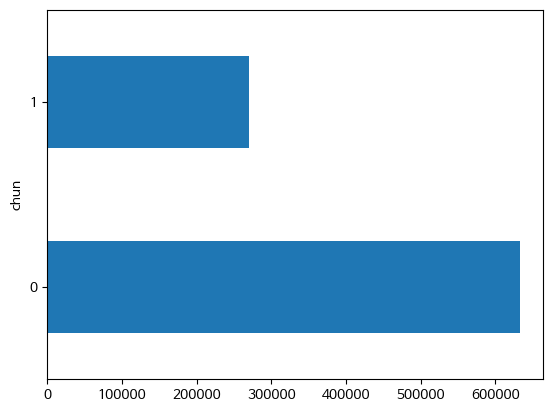

In [101]:
print(df['chun'].value_counts())
print(df['chun'].value_counts(normalize = True))

df['chun'].value_counts().plot(kind = 'barh')
plt.show()

In [102]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
payment_method,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,Credit Card,LinkAja,Gopay
payment_status,Success,Success,Success,Success,Success,Failed,Success,Success,Success,Success
promo_amount,8073,0,8828,3415,2645,0,0,5161,4656,5319
shipment_fee,0,10000,10000,0,10000,0,10000,15000,10000,5000
total_amount,826597,163784,124932,247902,181237,217298,386296,313310,342672,927135
shipment_date,1,3,5,3,3,2,4,4,3,3
customer_type,1,1,1,1,1,1,1,1,1,1
gender_y,M,M,M,M,M,M,M,M,M,M
device_type,Android,Android,Android,Android,Android,Android,Android,Android,Android,Android
home_location,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya,Jakarta Raya


In [103]:
# X,y로 나누기
target = 'chun'
X = df.drop(target, axis=1)
y = df[target]

# train, validation, test 데이터 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.8, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, train_size=0.8, random_state=42)

# 확인
print('학습용:', X_train.shape, y_train.shape)
print('검증용:', X_val.shape, y_val.shape)
print('평가용:', X_test.shape, y_test.shape)

학습용: (577490, 13) (577490,)
검증용: (144373, 13) (144373,)
평가용: (180466, 13) (180466,)


In [104]:
# 기준 모델 생성
baseline = [y_train.mode()[0]] * len(y_train)

훈련 정확도 0.7010372473982234
              precision    recall  f1-score   support

           0       0.70      1.00      0.82    404842
           1       0.00      0.00      0.00    172648

    accuracy                           0.70    577490
   macro avg       0.35      0.50      0.41    577490
weighted avg       0.49      0.70      0.58    577490



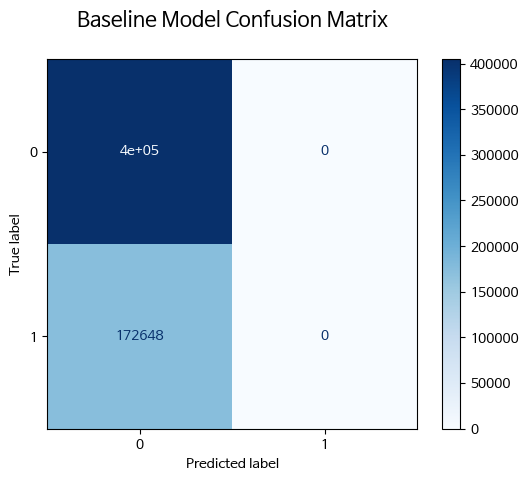

In [105]:
# Classification report
print("훈련 정확도", accuracy_score(y_train, baseline))
print(
    classification_report(
        y_train, baseline)
    )

# Confusion matrix
cm = confusion_matrix(y_train, baseline)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Baseline Model Confusion Matrix\n", size=15)
plt.show()

RandomForest

훈련 정확도:  0.9956172401253701
검증 정확도:  0.6933706440955026
평가 정확도:  0.6959094787937894
              precision    recall  f1-score   support

           0       0.73      0.90      0.80    101211
           1       0.47      0.21      0.29     43162

    accuracy                           0.69    144373
   macro avg       0.60      0.55      0.55    144373
weighted avg       0.65      0.69      0.65    144373



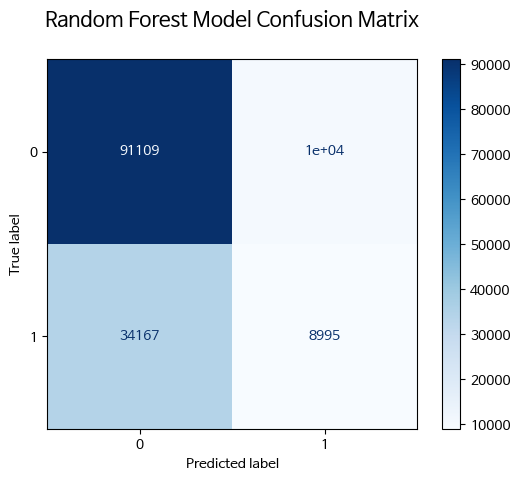

In [106]:
# RandomForest 모델 파이프라인 생성
pipe_rf = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        RandomForestClassifier(random_state = 42)
)

# 모델 학습
pipe_rf.fit(X_train, y_train)

# 모델 검증
y_pred_val = pipe_rf.predict(X_val)

# 정확도 확인
print('훈련 정확도: ', pipe_rf.score(X_train, y_train))
print('검증 정확도: ', pipe_rf.score(X_val, y_val))
print('평가 정확도: ', pipe_rf.score(X_test, y_test))

# Classification report
print(
    classification_report(
        y_val, y_pred_val)
    )

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Random Forest Model Confusion Matrix\n", size=15)
plt.show()

훈련 정확도:  0.7010372473982234
검증 정확도:  0.7010382827814065
평가 정확도:  0.7010406392339832
              precision    recall  f1-score   support

           0       0.70      1.00      0.82    101211
           1       0.00      0.00      0.00     43162

    accuracy                           0.70    144373
   macro avg       0.35      0.50      0.41    144373
weighted avg       0.49      0.70      0.58    144373



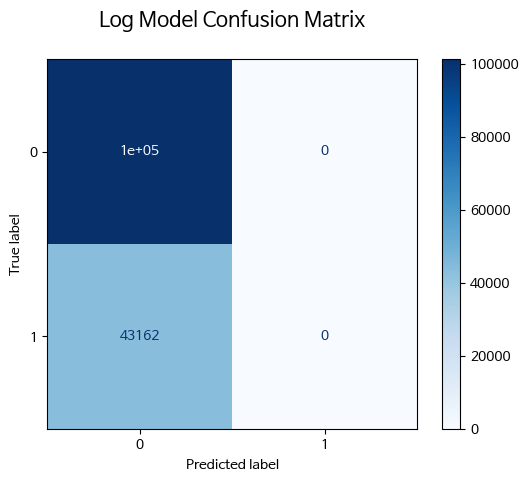

In [107]:
# Log 모델 파이프라인 생성
pipe_Log = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        LogisticRegression(random_state = 42)
)

# 모델 학습
pipe_Log.fit(X_train, y_train)

# 모델 검증
y_pred_val = pipe_Log.predict(X_val)

# 정확도 확인
print('훈련 정확도: ', pipe_Log.score(X_train, y_train))
print('검증 정확도: ', pipe_Log.score(X_val, y_val))
print('평가 정확도: ', pipe_Log.score(X_test, y_test))

# Classification report
print(
    classification_report(
        y_val, y_pred_val)
    )

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("Log Model Confusion Matrix\n", size=15)
plt.show()

훈련 정확도:  0.7156279762420128
검증 정확도:  0.712425453512776
평가 정확도:  0.7137798809748097
              precision    recall  f1-score   support

           0       0.71      0.99      0.83    101211
           1       0.74      0.06      0.11     43162

    accuracy                           0.71    144373
   macro avg       0.72      0.53      0.47    144373
weighted avg       0.72      0.71      0.61    144373



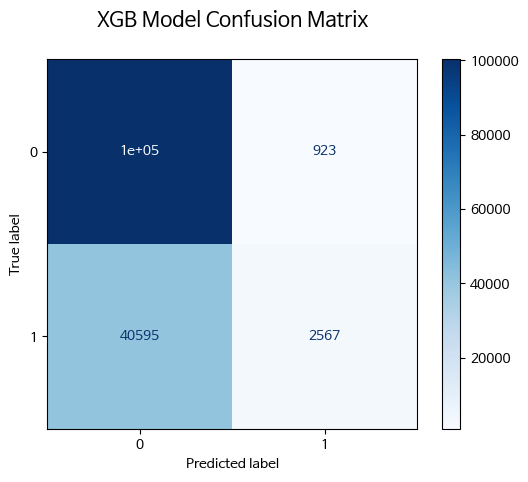

In [108]:
# XGB 모델 파이프라인 생성
pipe_xgb = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        XGBClassifier(random_state = 42)
)

# 모델 학습
pipe_xgb.fit(X_train, y_train)

# 모델 검증
y_pred_val = pipe_xgb.predict(X_val)

# 정확도 확인
print('훈련 정확도: ', pipe_xgb.score(X_train, y_train))
print('검증 정확도: ', pipe_xgb.score(X_val, y_val))
print('평가 정확도: ', pipe_xgb.score(X_test, y_test))

# Classification report
print(
    classification_report(
        y_val, y_pred_val)
    )

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("XGB Model Confusion Matrix\n", size=15)
plt.show()

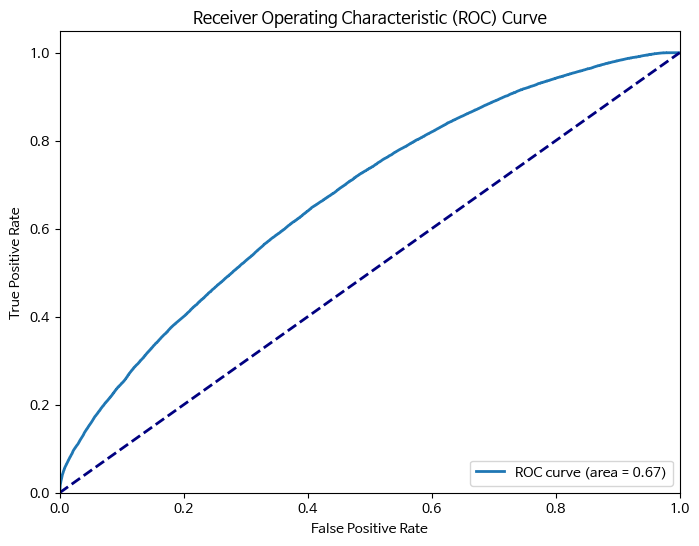

In [109]:
# 모델 검증
y_pred_val = pipe_xgb.predict(X_val)
y_pred_proba_val = pipe_xgb.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 예측 확률 추출

# ROC 커브 생성
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba_val)

# ROC 커브 그리기
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.2f)' % roc_auc_score(y_val, y_pred_proba_val))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

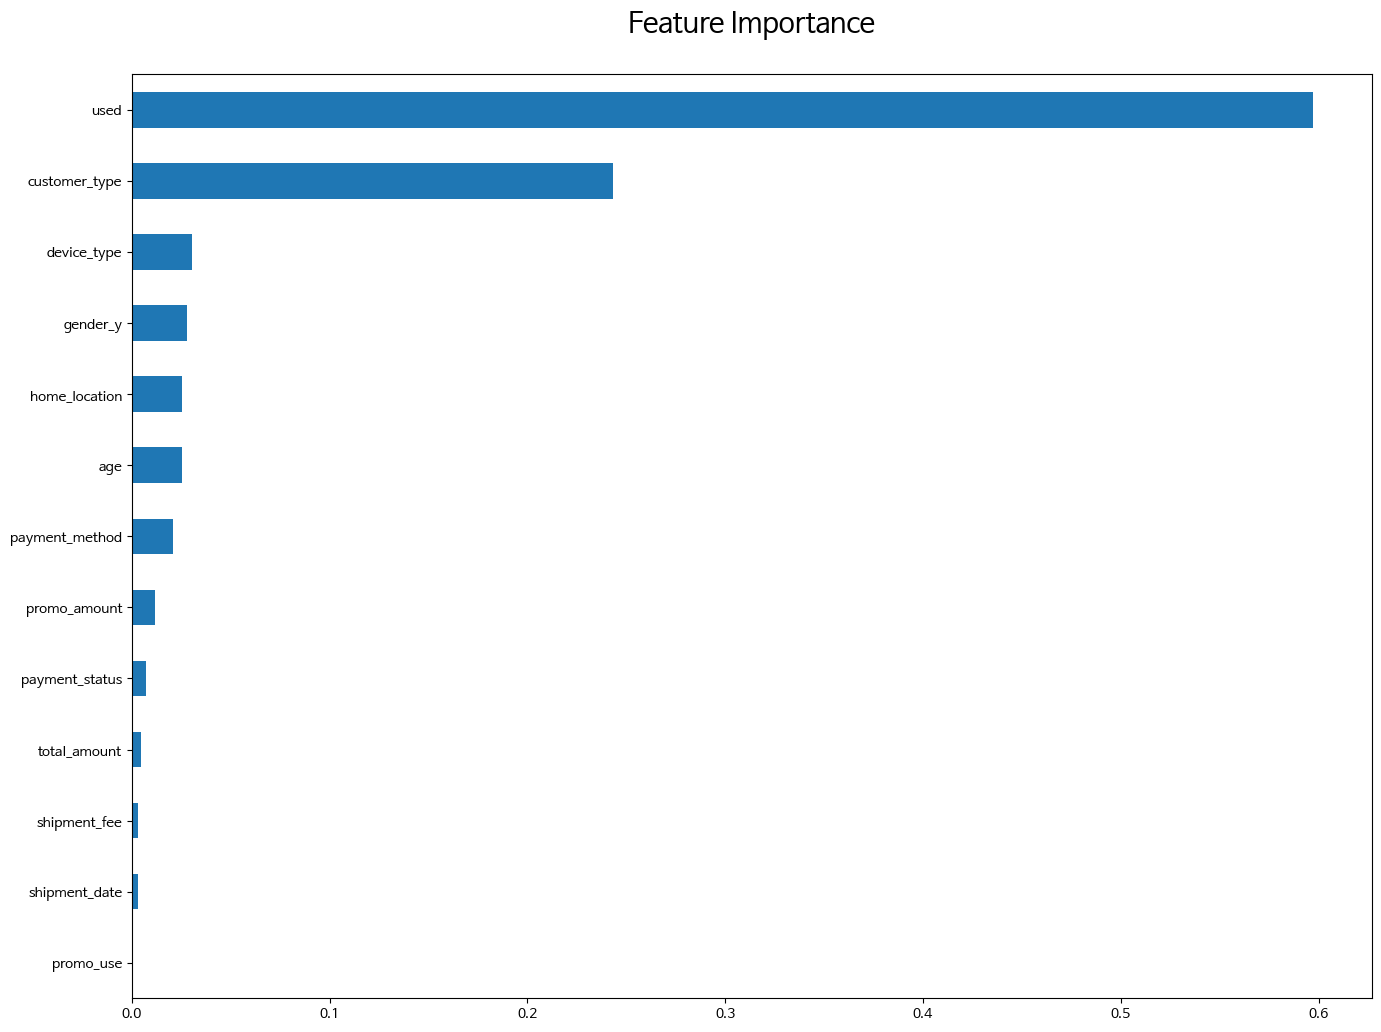

In [110]:
# 특성 중요도
xgb = pipe_xgb.named_steps["xgbclassifier"]
importances = pd.Series(xgb.feature_importances_, X_train.columns)
plt.figure(figsize=(16, 12))
importances.sort_values().plot.barh()
plt.title("Feature Importance\n", size=20)
plt.show()

In [113]:
# 최적 파라미터 찾기기 위한 파이프 라인 구성 - 랜덤 서치
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        random_state=42,
        scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum()
    ),
)

from scipy.stats.distributions import uniform

params = {
    "xgbclassifier__max_depth": [3,5,7,10,15],
    "xgbclassifier__learning_rate": [0.05, 0.1, 0.3],
    "xgbclassifier__n_estimators": [100,200,300,400,500],
    "xgbclassifier__colsample_bytree": [0.8,0.9]
}

from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring={"recall": "recall", "roc_auc": "roc_auc", "accuracy": "accuracy"}, 
    refit="accuracy", 
    cv=3,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 accuracy: ", randomized_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=15, xgbclassifier__n_estimators=400; recall: (test=0.530) roc_auc: (test=0.711) total time= 8.2min
[CV 2/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=15, xgbclassifier__n_estimators=400; recall: (test=0.533) roc_auc: (test=0.716) total time= 8.0min
[CV 3/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.3, xgbclassifier__max_depth=15, xgbclassifier__n_estimators=400; recall: (test=0.536) roc_auc: (test=0.718) total time=10.0min
[CV 1/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=10, xgbclassifier__n_estimators=400; recall: (test=0.746) roc_auc: (test=0.700) total time=11.4min
[CV 2/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.05, xgbclassifier__max_de

In [117]:
# 최적 파라미터 찾기기 위한 파이프 라인 구성 - 랜덤 서치
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        random_state=42,
        scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum()
    ),
)

from scipy.stats.distributions import uniform

params = {
    "xgbclassifier__max_depth": [7,10,13,14,16],
    "xgbclassifier__learning_rate": [0.05, 0.01, 0.08],
    "xgbclassifier__n_estimators": [300,400,500,600,700],
    "xgbclassifier__colsample_bytree": [0.8,0.9]
}

from sklearn.model_selection import RandomizedSearchCV

randomized_search = RandomizedSearchCV(
    pipe,
    param_distributions=params,
    scoring={"recall": "recall", "roc_auc": "roc_auc", "accuracy": "accuracy"}, 
    refit="accuracy", 
    cv=3,
    verbose=3,
    random_state=42,
)
randomized_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", randomized_search.best_params_)
print("최적 accuracy: ", randomized_search.best_score_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.08, xgbclassifier__max_depth=16, xgbclassifier__n_estimators=600; accuracy: (test=0.686) recall: (test=0.602) roc_auc: (test=0.734) total time=11.8min
[CV 2/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.08, xgbclassifier__max_depth=16, xgbclassifier__n_estimators=600; accuracy: (test=0.685) recall: (test=0.598) roc_auc: (test=0.730) total time=11.7min
[CV 3/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.08, xgbclassifier__max_depth=16, xgbclassifier__n_estimators=600; accuracy: (test=0.691) recall: (test=0.600) roc_auc: (test=0.738) total time=11.8min
[CV 1/3] END xgbclassifier__colsample_bytree=0.8, xgbclassifier__learning_rate=0.05, xgbclassifier__max_depth=14, xgbclassifier__n_estimators=600; accuracy: (test=0.659) recall: (test=0.664) roc_auc: (test=0.728) total time= 9.9min
[CV 2/3] EN

훈련 정확도:  0.6318983878508718
검증 정확도:  0.6027996924632723
평가 정확도:  0.6063635255394368
              precision    recall  f1-score   support

           0       0.83      0.54      0.66    101211
           1       0.41      0.74      0.53     43162

    accuracy                           0.60    144373
   macro avg       0.62      0.64      0.59    144373
weighted avg       0.70      0.60      0.62    144373



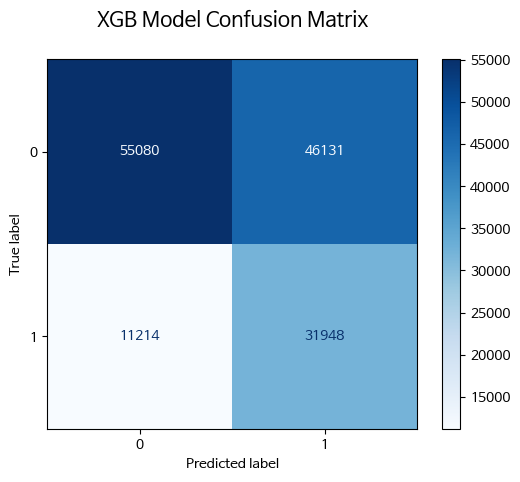

In [116]:
# XGB 모델 파이프라인 생성
pipe_xgb = make_pipeline(OrdinalEncoder(),
                        SimpleImputer(),
                        XGBClassifier(
                            objective="binary:logistic",
                            random_state = 42,
                            eval_metric="error",
                            scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum(),
                            n_estimators = 400,
                            max_depth = 10,
                            learning_rate = 0.05,
                            colsample_bytree = 0.8
                            )
)

# 모델 학습
pipe_xgb.fit(X_train, y_train)

# 모델 검증
y_pred_val = pipe_xgb.predict(X_val)

# 정확도 확인
print('훈련 정확도: ', pipe_xgb.score(X_train, y_train))
print('검증 정확도: ', pipe_xgb.score(X_val, y_val))
print('평가 정확도: ', pipe_xgb.score(X_test, y_test))

# Classification report
print(
    classification_report(
        y_val, y_pred_val)
    )

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_val)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("XGB Model Confusion Matrix\n", size=15)
plt.show()

In [65]:
# 최적 파라미터 찾기기 위한 파이프 라인 구성 - 그리드 서치
pipe = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy="median"),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",
        random_state=42,
        scale_pos_weight=(y_val == 0).sum() / (y_val == 1).sum()
    ),
)

params = {
    "xgbclassifier__max_depth": [3,5,7,10,15],
    "xgbclassifier__learning_rate": [0.05, 0.1, 0.3],
    "xgbclassifier__n_estimators": [100,200,300,400,500],
    "xgbclassifier__colsample_bytree": [0.8,0.9]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipe, param_grid=params, scoring="roc_auc", cv=3, verbose=3)
grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터: ", grid_search.best_params_)
print("최적 AUC: ", grid_search.best_score_)

Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='error',
                               feature_types=None, gamma=None, gpu...one,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing

KeyboardInterrupt: 